In [1]:
import matplotlib.pyplot as plt
import scipy.integrate
import torch
import sys  
sys.path.insert(0, '..')

from hnn.simulation import get_dataset, get_field, get_trajectory, get_vector_field, integrate_model
from hnn.train import train

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--total_steps', default=2000, type=int, help='number of gradient steps')
    parser.add_argument('--name', default='pend', type=str, help='only one option right now')
    parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn')
    parser.set_defaults(feature=True)
    return parser.parse_args()

In [3]:
args = get_args()
model, stats = train(args)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/kristinlindquist/development/pinns/src/hnn/../hnn/train.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data["x"], requires_grad=True, dtype=torch.float32)
/Users/kristinlindquist/development/pinns/src/hnn/../hnn/train.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

step 0, train_loss 6.1559e+00, test_loss 5.4014e+00
step 1, train_loss 5.7846e+00, test_loss 5.0538e+00
step 2, train_loss 5.4359e+00, test_loss 4.7269e+00
step 3, train_loss 5.1060e+00, test_loss 4.4175e+00
step 4, train_loss 4.7922e+00, test_loss 4.1242e+00
step 5, train_loss 4.4931e+00, test_loss 3.8463e+00
step 6, train_loss 4.2082e+00, test_loss 3.5833e+00
step 7, train_loss 3.9371e+00, test_loss 3.3343e+00
step 8, train_loss 3.6791e+00, test_loss 3.0979e+00
step 9, train_loss 3.4330e+00, test_loss 2.8727e+00
step 10, train_loss 3.1975e+00, test_loss 2.6569e+00
step 11, train_loss 2.9712e+00, test_loss 2.4491e+00
step 12, train_loss 2.7528e+00, test_loss 2.2484e+00
step 13, train_loss 2.5415e+00, test_loss 2.0540e+00
step 14, train_loss 2.3367e+00, test_loss 1.8658e+00
step 15, train_loss 2.1381e+00, test_loss 1.6839e+00
step 16, train_loss 1.9460e+00, test_loss 1.5088e+00
step 17, train_loss 1.7606e+00, test_loss 1.3412e+00
step 18, train_loss 1.5827e+00, test_loss 1.1824e+00
ste

In [ ]:
GRID_SIZE=10
R = 2.5
t_span=[0, 28]
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

In [5]:

field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=GRID_SIZE)
data = get_dataset(radius=2.0)
vector_field = get_vector_field(model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=GRID_SIZE)

# integrate along those fields starting from point (1,0)
ivp = integrate_model(
        model,
        t_span,
        y0=torch.tensor([2.1, 0]),
        t_eval=torch.linspace(t_span[0], t_span[1], 1000),
        rtol=1e-12
)


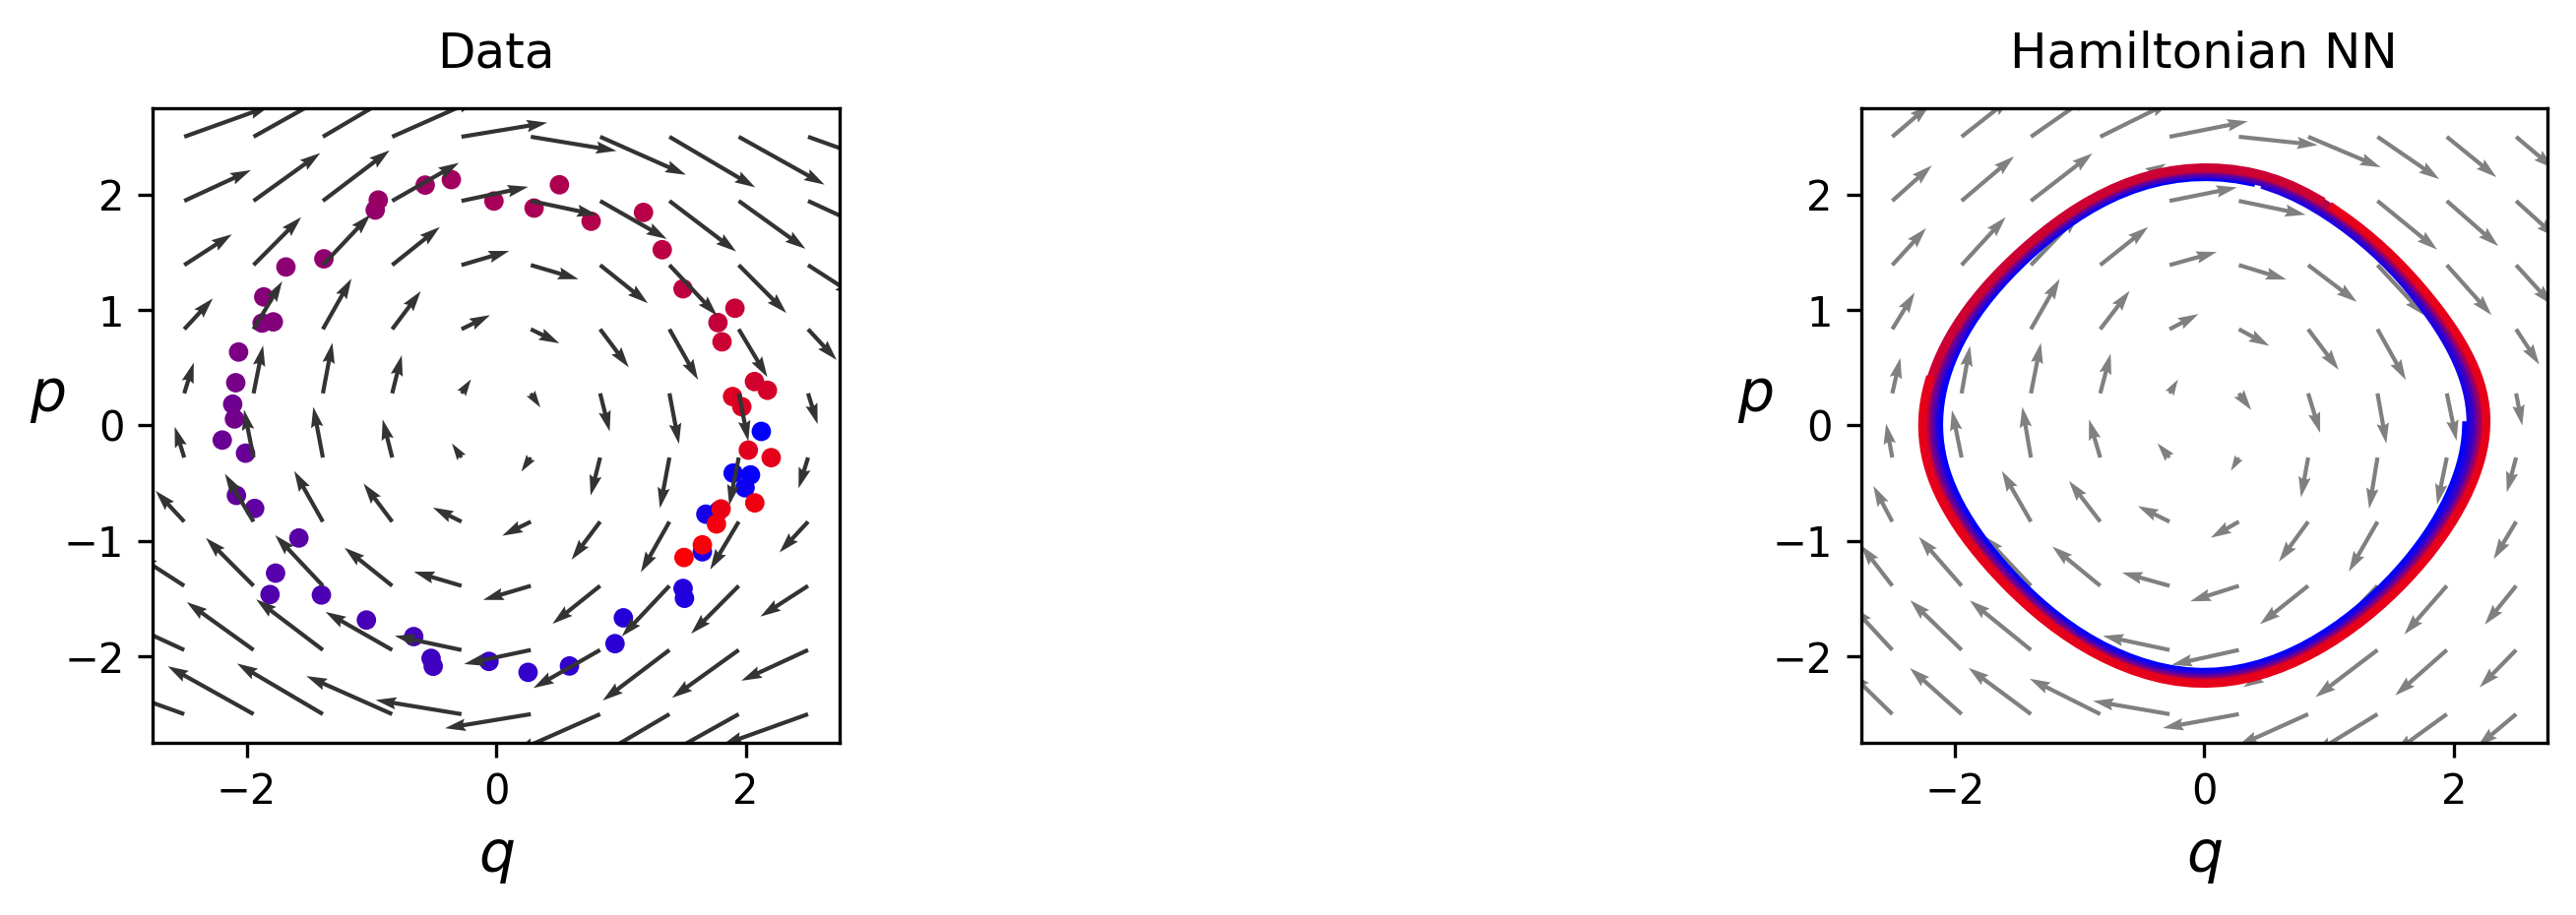

In [37]:
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=300)

# plot data
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0,4], radius=2.1, y0=torch.tensor([2.1, 0]))
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)
plt.quiver(
        field['x'][:,0],
        field['x'][:,1],
        field['dx'][:,0],
        field['dx'][:,1],
        cmap='gray_r',
        scale=ARROW_SCALE,
        width=ARROW_WIDTH,
        color=(.2,.2,.2)
)  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(
        field['x'][:,0],
        field['x'][:,1],
        vector_field[:,0],
        vector_field[:,1],
        cmap='gray_r',
        scale=ARROW_SCALE,
        width=ARROW_WIDTH,
        color=(.5,.5,.5)
)

for i, l in enumerate(torch.tensor_split(torch.tensor(ivp['y'].T), LINE_SEGMENTS)):
        color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
        plt.plot(l[:,0], l[:,1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.tight_layout() ; plt.show()